# COVID-19 cases in Kenya, preprocessing analysis

In [52]:
#load some key libraries

import pandas as pd
import datetime as dt
from datetime import date
import calendar
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
#select_important_columns
#covid_data_original = pd.read_excel("Covid-19_cleaned_07-02-2022.xls", engine="xlrd")
covid_data_original = pd.read_table("Covid-19_cleaned_07-02-2022.txt")

covid_data_original["county_where_the_case_was_diagonised"] =  covid_data_original["county_where_the_case_was_diagonised"].\
                                                            apply(lambda x : str(x).title())
covid_data_original["county_where_the_case_was_diagonised"] = covid_data_original["county_where_the_case_was_diagonised"].\
                    replace({"Murang'A": "Murang'a", "Kakamega ": "Kakamega", "Nakuru ": "Nakuru", "Kajiado ":"Kajiado"})


covid_data_original.head()

/var/folders/0x/t7x8m9311b1gnnb39j773h8c3q8zn2/T/ipykernel_7815/2193926576.py:3: DtypeWarning: Columns (2,3,15,16,17,25,26,28,29,35,36,37,38,39,40,42,45,46,47,48,49,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  covid_data_original = pd.read_table("Covid-19_cleaned_07-02-2022.txt")


,unique_id,case_id,contact_of_new,age_years,sex,occupation_sector_job_title_employer_,county_of_residence,county_where_the_case_was_diagonised,nationality,sub_county,...,co_morbidity,management,status_need,date_of_announcement_by_cs,type_of_testing,graph_date,status,total_deaths,history_of_contact_new,symptomatic_yes_no_new
0,Case-01,Case 1,NaN,27.0,F,/Unemployed,Kajiado,Kajiado,Kenyan,Kajiado North,...,NaN,NaN,NaN,13-Mar-20,PCR,NaN,#ERROR!,1241,NaN,YES
1,Case-02,Case 2,NaN,48.0,F,/Unknown,Nairobi,Nairobi,Kenyan,Starehe,...,NaN,NaN,NaN,NaN,PCR,NaN,#ERROR!,NaN,NaN,YES
2,Case-03,Case 3,Case-01,27.0,M,/Unknown,Nairobi,Nairobi,Kenyan,Kajiado North,...,NaN,NaN,NaN,NaN,PCR,NaN,#ERROR!,NaN,YES,YES
3,Case-04,Case 4,NaN,31.0,F,/Unknown,Nairobi,Nairobi,Kenyan,Langata,...,NaN,NaN,NaN,NaN,PCR,NaN,#ERROR!,NaN,NaN,YES
4,Case-05,Case 5,NaN,42.0,F,/Unknown,Nairobi,Nairobi,Kenyan,Westlands,...,NaN,NaN,NaN,NaN,PCR,NaN,#ERROR!,NaN,NaN,YES


In [51]:
covid_data_original["lab_results"].value_counts()

Positive                                    319296
12/15/2020                                     313
Yes                                            271
CDC Kisumu Laboratory                           97
Nyanza Provincial General Hospital (PGH)        66
12/16/2020                                      42
12/14/2020                                      34
Pathologists Lancet Kenya                       29
Kitale District Hospital                        23
CDC Nairobi Laboratory                          19
IOM Kenya                                       18
KEMRI WRP Kericho                               16
Coast Province General Hospital                 14
The Mater Hospital Mukuru                       13
KEMRI P3 Nairobi                                12
Mombasa Hospital                                12
Makueni County Head Quarters                    10
Moi Teaching Refferal Hospital                   9
Aga Khan Hospital                                9
Nairobi West Hospital          

Visualizing lab_results column returns presence of wrong labels and names of hospitals. Creating a new colum fpor confirmed positives. This will determine the total cases

In [3]:
covid_data = covid_data_original[["unique_id","age_years", "sex","county_of_residence","county_where_the_case_was_diagonised",
                                    "status_need","status","lab_results","date_of_lab_confirmation","outcome_death_Discharge_still_in_hospital_"]]

covid_data.tail()

,unique_id,age_years,sex,county_of_residence,county_where_the_case_was_diagonised,status_need,status,lab_results,date_of_lab_confirmation,outcome_death_Discharge_still_in_hospital_
322122,Case-0322092,21.0,F,Siaya,Siaya,NaN,NaN,NaN,05/02/2022,NaN
322123,Case-0322093,2.0,M,Siaya,Siaya,NaN,NaN,NaN,05/02/2022,NaN
322124,Case-0322094,70.0,M,Tharaka Nithi,Tharaka Nithi,NaN,NaN,NaN,05/02/2022,NaN
322125,Case-0322095,15.0,F,Uasin Gishu,Uasin Gishu,NaN,NaN,NaN,05/02/2022,NaN
322126,Case-0322096,43.0,M,Uasin Gishu,Uasin Gishu,NaN,NaN,NaN,05/02/2022,NaN


In [4]:
#convert the date column to true dates
covid_data["date_of_lab_confirmation"] = pd.to_datetime(covid_data["date_of_lab_confirmation"], format="%d/%m/%Y", errors="coerce")

/var/folders/0x/t7x8m9311b1gnnb39j773h8c3q8zn2/T/ipykernel_7815/2772849741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_data["date_of_lab_confirmation"] = pd.to_datetime(covid_data["date_of_lab_confirmation"], format="%d/%m/%Y", errors="coerce")


## Plots based on lab_results and outcome from hospitals

In [5]:
covid_data_view = covid_data[[ "sex","age_years", "lab_results", "date_of_lab_confirmation", "outcome_death_Discharge_still_in_hospital_" , "county_where_the_case_was_diagonised"]]

#there exists some cases with missing date of lab confirmation. Dropping them
covid_data_view=covid_data_view.dropna(subset=["date_of_lab_confirmation"])

covid_data_view.tail()

,sex,age_years,lab_results,date_of_lab_confirmation,outcome_death_Discharge_still_in_hospital_,county_where_the_case_was_diagonised
322122,F,21.0,NaN,2022-02-05,NaN,Siaya
322123,M,2.0,NaN,2022-02-05,NaN,Siaya
322124,M,70.0,NaN,2022-02-05,NaN,Tharaka Nithi
322125,F,15.0,NaN,2022-02-05,NaN,Uasin Gishu
322126,M,43.0,NaN,2022-02-05,NaN,Uasin Gishu


In [6]:
covid_data_view["Year"] = covid_data_view["date_of_lab_confirmation"].dt.to_period("Y")
covid_data_view["Month"] =  covid_data_view["date_of_lab_confirmation"].dt.month
covid_data_view["Week"] = covid_data_view["date_of_lab_confirmation"].dt.week
covid_data_view["Month"] =  covid_data_view["Month"].apply(lambda x: calendar.month_abbr[x])
covid_data_view["Month_year"] = covid_data_view["date_of_lab_confirmation"].dt.to_period("M")
covid_data_view["year_month"] = covid_data_view["Month"] + "-" +  covid_data_view["Year"].astype(str) 
covid_data_view.head()

/var/folders/0x/t7x8m9311b1gnnb39j773h8c3q8zn2/T/ipykernel_7815/3999872376.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  covid_data_view["Week"] = covid_data_view["date_of_lab_confirmation"].dt.week


,sex,age_years,lab_results,date_of_lab_confirmation,outcome_death_Discharge_still_in_hospital_,county_where_the_case_was_diagonised,Year,Month,Week,Month_year,year_month
0,F,27.0,Positive,2020-03-12,Discharge,Kajiado,2020,Mar,11,2020-03,Mar-2020
1,F,48.0,Positive,2020-03-14,Discharge,Nairobi,2020,Mar,11,2020-03,Mar-2020
2,M,27.0,Positive,2020-03-14,Discharge,Nairobi,2020,Mar,11,2020-03,Mar-2020
3,F,31.0,Positive,2020-03-17,Discharge,Nairobi,2020,Mar,12,2020-03,Mar-2020
4,F,42.0,Positive,2020-03-17,Discharge,Nairobi,2020,Mar,12,2020-03,Mar-2020


In [7]:
Monthly_cases = covid_data_view[["Month_year", "year_month", "outcome_death_Discharge_still_in_hospital_" ,"lab_results"]].\
    groupby(["Month_year", "year_month"])["Month_year"].count().to_frame(name = "COVID19_Cases").reset_index()
Monthly_cases.rename(columns = {"COVID19_Cases": "Reported_cases"}, inplace=True)

death_cases = covid_data_view[covid_data_view["outcome_death_Discharge_still_in_hospital_"] == "Dead"]
monthly_death_cases = death_cases[["outcome_death_Discharge_still_in_hospital_","Month_year", "year_month"]].\
    groupby(["Month_year", "year_month"]).count().reset_index()
monthly_death_cases.rename(columns = {"outcome_death_Discharge_still_in_hospital_" : "Death_cases"}, inplace=True)

covid_monthly_data = pd.merge(Monthly_cases, monthly_death_cases, on = "year_month", how = "outer")
covid_monthly_data =  covid_monthly_data.drop("Month_year_x", axis=1)
covid_monthly_data =  covid_monthly_data.rename(columns={"Month_year_y" : "Month_year"})
covid_monthly_data["Month_year"]= covid_monthly_data["Month_year"].dt.strftime("%Y-%m")

covid_monthly_data.to_csv("covid_monthly_data.csv")


In [8]:
Monthly_cases = pd.read_csv("covid_monthly_data.csv")

Monthly_cases.head()

,Unnamed: 0,year_month,Reported_cases,Month_year,Death_cases
0,0,Mar-2020,84,2020-03,5
1,1,Apr-2020,350,2020-04,20
2,2,May-2020,1701,2020-05,66
3,3,Jun-2020,4719,2020-06,134
4,4,Jul-2020,14480,2020-07,347


Daily Cases

In [9]:
#summary for daily reported dcases
daily_cases =  covid_data_view[["date_of_lab_confirmation", "lab_results"]].groupby("date_of_lab_confirmation")["date_of_lab_confirmation"].\
    count().to_frame(name = "Reported_Cases").reset_index()
daily_cases.rename(columns = {"date_of_lab_confirmation": "Date"}, inplace=True)
#daily_cases.tail()

#summary for dail deaths
daily_deaths = covid_data[covid_data["outcome_death_Discharge_still_in_hospital_"] == "Dead"]
daily_deaths = daily_deaths[[ "date_of_lab_confirmation", "outcome_death_Discharge_still_in_hospital_" ]].\
    groupby("date_of_lab_confirmation")["date_of_lab_confirmation"].count().to_frame(name="death_cases").reset_index()
daily_deaths.rename(columns = {"date_of_lab_confirmation": "Date"}, inplace=True)

#summary for dicharged
daily_discharges = covid_data[covid_data["outcome_death_Discharge_still_in_hospital_"] == "Discharge"]
daily_discharges = daily_discharges[[ "date_of_lab_confirmation", "outcome_death_Discharge_still_in_hospital_" ]].\
    groupby("date_of_lab_confirmation")["date_of_lab_confirmation"].count().to_frame(name="Reported_discharges").reset_index()
daily_discharges.rename(columns = {"date_of_lab_confirmation": "Date"}, inplace=True)

covid_daily_data = pd.merge(pd.merge(daily_cases, daily_deaths, how = "outer"), daily_discharges, how="outer")

covid_daily_data["death_cases"] = covid_daily_data["death_cases"].fillna(0)
covid_daily_data["Reported_discharges"] = covid_daily_data["Reported_discharges"].fillna(0)

covid_daily_data = covid_daily_data.astype({"Reported_Cases":int, "death_cases": int, "Reported_discharges":int })
covid_daily_data["Cum_Cases"] = covid_daily_data["Reported_Cases"].cumsum()
covid_daily_data["Cum_Deaths"] = covid_daily_data["death_cases"].cumsum()
covid_daily_data.to_csv("covid_daily_data.csv")
covid_daily_data.head()

covid_daily_data.to_csv("covid_daily_data.csv")
covid_daily_data.head()

,Date,Reported_Cases,death_cases,Reported_discharges,Cum_Cases,Cum_Deaths
0,2020-03-12,1,0,1,1,0
1,2020-03-14,2,0,2,3,0
2,2020-03-17,4,0,4,7,0
3,2020-03-19,3,0,3,10,0
4,2020-03-20,1,0,1,11,0


In [10]:
fig = go.Figure(data = go.Scatter(x = covid_daily_data["Date"],y = covid_daily_data["Cum_Cases"], fill = "tozeroy",marker=dict(color = "#3D59AB")))

fig.show()

In [11]:
from plotly.graph_objects import Layout
layout = Layout(plot_bgcolor="rgba(0,0,0,0)")
fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter( x = covid_daily_data["Date"],  y = covid_daily_data["Reported_Cases"],mode='none',
                            fill = 'tozeroy', marker = dict(color = "#A3A3A3")))
fig.update_layout(title = "COVID-19 Monthly Cases", font_color = "darkcyan")
fig.update_yaxes(title =  "Counts", showline=True, linewidth = 0.2, linecolor = "gray", gridcolor = "gainsboro")
fig.update_xaxes(title = "Period", showgrid=False)
fig.show()

Weekly Cases

In [12]:
#export data

covid_data.to_csv("covid_data_processed.csv")

In [13]:
#filter data for those who died
dead = covid_data[covid_data["outcome_death_Discharge_still_in_hospital_"] == "Dead"]
daily_deaths = dead[[ "date_of_lab_confirmation", "outcome_death_Discharge_still_in_hospital_" ]].\
    groupby("date_of_lab_confirmation")["date_of_lab_confirmation"].count().to_frame(name="death_cases").reset_index()
daily_deaths.rename(columns = {"date_of_lab_confirmation": "Date"}, inplace=True)

daily_deaths.to_csv("death_cases.csv")

from plotly.graph_objects import Layout
layout = Layout(plot_bgcolor="rgba(0,0,0,0)")
fig5 = go.Figure(layout=layout)
fig5.add_trace(go.Scatter( x = daily_deaths.Date,  y = daily_deaths.death_cases,mode='none',
                            fill = 'tozeroy', marker = dict(color = "#A3A3A3")))
fig5.update_layout(title = "COVID-19 Daily Deaths", font_color = "darkcyan")
fig5.update_yaxes(title =  "Deaths Cases", showline=True, linewidth = 0.2, linecolor = "gray", gridcolor = "gainsboro")
fig5.update_xaxes(title = "Period", showgrid=False)
#fig.show()

## Visualization Based on County where case was diagnoised


In [14]:
covid_data_view.head()


,sex,age_years,lab_results,date_of_lab_confirmation,outcome_death_Discharge_still_in_hospital_,county_where_the_case_was_diagonised,Year,Month,Week,Month_year,year_month
0,F,27.0,Positive,2020-03-12,Discharge,Kajiado,2020,Mar,11,2020-03,Mar-2020
1,F,48.0,Positive,2020-03-14,Discharge,Nairobi,2020,Mar,11,2020-03,Mar-2020
2,M,27.0,Positive,2020-03-14,Discharge,Nairobi,2020,Mar,11,2020-03,Mar-2020
3,F,31.0,Positive,2020-03-17,Discharge,Nairobi,2020,Mar,12,2020-03,Mar-2020
4,F,42.0,Positive,2020-03-17,Discharge,Nairobi,2020,Mar,12,2020-03,Mar-2020


In [15]:
covid_data.head()

,unique_id,age_years,sex,county_of_residence,county_where_the_case_was_diagonised,status_need,status,lab_results,date_of_lab_confirmation,outcome_death_Discharge_still_in_hospital_
0,Case-01,27.0,F,Kajiado,Kajiado,NaN,#ERROR!,Positive,2020-03-12,Discharge
1,Case-02,48.0,F,Nairobi,Nairobi,NaN,#ERROR!,Positive,2020-03-14,Discharge
2,Case-03,27.0,M,Nairobi,Nairobi,NaN,#ERROR!,Positive,2020-03-14,Discharge
3,Case-04,31.0,F,Nairobi,Nairobi,NaN,#ERROR!,Positive,2020-03-17,Discharge
4,Case-05,42.0,F,Nairobi,Nairobi,NaN,#ERROR!,Positive,2020-03-17,Discharge


In [16]:
covid_data["county_where_the_case_was_diagonised"].unique()

array(['Kajiado', 'Nairobi', 'Kwale', 'Kilifi', 'Mombasa', 'Kakamega',
       'Kitui', 'Nakuru', 'Mandera', 'Uasin Gishu', 'Siaya', 'Homa Bay',
       'Kiambu', 'Wajir', 'Makueni', 'Migori', 'Bungoma', 'Busia',
       'Isiolo', 'Machakos', 'Bomet', 'Taita Taveta', 'Garissa', 'Kisii',
       'Meru', 'Kirinyaga', 'Trans Nzoia', 'Kisumu', 'Turkana', 'Embu',
       'Nyeri', "Murang'a", 'Kericho', 'Laikipia', 'Nandi',
       'Elgeyo Marakwet', 'Marsabit', 'Narok', 'Nyamira', 'Vihiga',
       'Lamu', 'Nyandarua', 'Tharaka Nithi', 'Tana River', 'Nan',
       'Sore Throat, General Body Malaise, Stomach Upset.', 'Baringo',
       'West Pokot', 'Samburu', '13/08/2020', '02/09/2020', '13/10/2020',
       '15/10/2020', '16/10/2020', '0021-01-27', 'Makueni ', '0021-03-06',
       '0021-03-08', '0021-03-13'], dtype=object)

In [17]:
#covid_data.rename(columns = {"county_where_the_case_was_diagonised" :"County"}, inplace=True)
county_death = covid_data[covid_data["outcome_death_Discharge_still_in_hospital_"] == "Dead"]
#county_death.rename(columns = {"county_where_the_case_was_diagonised" :"County"}, inplace=True)

county_death_counts = county_death[["county_where_the_case_was_diagonised", "outcome_death_Discharge_still_in_hospital_"]].\
                        groupby("county_where_the_case_was_diagonised").count().reset_index()
                        
county_death_counts.rename(columns={"outcome_death_Discharge_still_in_hospital_": "Death_cases"}, inplace=True)
#county_death_counts

discharged = covid_data[covid_data["outcome_death_Discharge_still_in_hospital_"] == "Discharge"]
discharged = discharged[["county_where_the_case_was_diagonised", "outcome_death_Discharge_still_in_hospital_"]].\
                    groupby("county_where_the_case_was_diagonised").count().reset_index()
discharged.rename(columns={"outcome_death_Discharge_still_in_hospital_": "Discharged"}, inplace=True)
#discharged

#covid_data["county_of_residence"] = covid_data["county_where_the_case_was_diagonised"].str.strip().str.title()#.unique() #Needs clean-up for naming consistency
county_prevalence = covid_data.groupby("county_where_the_case_was_diagonised")["county_where_the_case_was_diagonised"].count().\
                to_frame(name = "cases").reset_index()
county_prevalence = county_prevalence.sort_values("cases", ascending=False)
#county_prevalence

county_cases = pd.merge(pd.merge(county_prevalence, county_death_counts, on="county_where_the_case_was_diagonised"),\
                    discharged,how="left", on="county_where_the_case_was_diagonised")

county_cases["Discharged"] = county_cases["Discharged"].fillna(0)
county_cases = county_cases.astype({"cases":int, "Death_cases": int, "Discharged":int })

county_cases.rename(columns={"county_where_the_case_was_diagonised": "County"}, inplace=True)

#include sequenced, vaccination, status
sequenced = [1302,201,179,169,105,78,76,76,70,65,64,58,58,49,44,42,41,37,33,32,31,31,30,27,27,26,23,23,23,21,21,20,17,17,14,13,\
                12,11,10,9,8,8,5,4,4,3,3]

samples_collected = [9114,8764,8544,8474,5454,3891,3801,3795,3492,3266,3201,2922,2881,2445,2219,2095,2040,1855,1673,1607,1569,\
                                            1534,1491,1329,1326,1313,1173,1173,1129,1053,1037,1019,841,839,685,667,619,545,499,\
                                                27,385,384,265,212,205,158,150]
Proportion_sequenced = [25.1,16.4,33.1,34.6,27.4,33.6,13.6,38.4,13.2,34.9,44.2,32.7,36.6,17.4,38.1,37.1,44.8,22.2,17.3,40.1,23.6,35.8,32.9,10.4,10.5,\
                        29.8,39.6,34.2,37.6,52.3,40.7,27,15.5,41.5,33,53.6,21.8,44.4,38.9,11,34.5,36.9,21.9,35,34.6,11.1,14.6]

df = pd.DataFrame(list(zip(sequenced, samples_collected,Proportion_sequenced)), 
                            columns = ["sequenced", "samples_collected","Proportion_sequenced"])

county_cases = pd.concat([county_cases, df], axis=1)

county_cases.to_csv("cases_per_county.csv")

county_cases.head()

,County,cases,Death_cases,Discharged,sequenced,samples_collected,Proportion_sequenced
0,Nairobi,130228,1542,3561,1302,9114,25.1
1,Kiambu,20127,545,263,201,8764,16.4
2,Mombasa,17887,337,1530,179,8544,33.1
3,Nakuru,16947,531,66,169,8474,34.6
4,Uasin Gishu,10507,241,111,105,5454,27.4


In [18]:
sample_bar = go.Bar(x = county_cases["County"], 
                    y = county_cases["samples_collected"],
                    name= "collected",
                    yaxis = "y1", offsetgroup=1,marker_color = "#FF7F0E"
                    )

sequenced_bar = go.Bar(x = county_cases["County"], 
                        y = county_cases["Proportion_sequenced"],
                        name  = "sequenced",
                        yaxis = "y2",
                        offsetgroup=2, marker_color = "#1F77B4")
data = [sample_bar, sequenced_bar]

layout = go.Layout( barmode = "group",hovermode="closest",
                        xaxis = dict(showline = True, ticks = "outside",tickfont = dict(size = 10)),
                        yaxis=dict(title='total samples collected',showgrid=True,showline=True, linewidth = 0.2, linecolor = "gray", gridcolor = "gainsboro"),
                        yaxis2=dict(title='proportion sequenced', side='right',overlaying='y',showgrid=False,showline=True, linewidth = 0.2, linecolor = "gray", gridcolor = "gainsboro"), 
                        paper_bgcolor="#FFF6F9", plot_bgcolor = "#FFF6F9",
                        legend = dict(x=0.3, y=1, traceorder="normal",orientation = "h"))

figure = go.Figure(data = data, layout= layout)

figure.show()

## Vaccination information

In [19]:
#data from ministry of health 

County = ["Baringo","Bomet","Bungoma","Busia","Elgeyo Marakwet","Embu","Garissa","Homa Bay","Isiolo","Kajiado","Kakamega","Kericho","Kiambu",\
    "Kilifi","Kirinyaga","Kisii","Kisumu","Kitui","Kwale","Laikipia","Lamu","Machakos","Makueni","Mandera","Marsabit","Meru","Migori","Mombasa",\
            "Murang'a","Nairobi","Nakuru","Nandi","Narok","Nyamira","Nyandarua","Nyeri","Samburu","Siaya","Taita Taveta","Tana River","Tharaka Nithi",\
                "Trans Nzoia","Turkana","Uasin Gishu","Vihiga","Wajir","West Pokot"]
Population_vaccinated = [84904,76594,279522,161039,66826,133100,54335,233810,17548,231369,434677,166407,594614,136859,157439,258899,293662,138916,\
                                78222,122869,19682,323810,192008,35563,22963,282518,220721,275349,253870,1597784,518376,132910,84855,141630,124173,\
                                    273192,31802,237793,82965,16606,85121,191032,102890,242715,113992,37371,41559]
                    
Proportion_vaccinated = [25.1,16.4,33.1,34.6,27.4,33.6,13.6,38.4,13.2,34.9,44.2,32.7,36.6,17.4,38.1,37.1,44.8,22.2,17.3,40.1,23.6,35.8,32.9,10.4,10.5,\
                        29.8,39.6,34.2,37.6,52.3,40.7,27,15.5,41.5,33,53.6,21.8,44.4,38.9,11,34.5,36.9,21.9,35,34.6,11.1,14.6]

vaccination_per_county = pd.DataFrame(list(zip(County, Population_vaccinated, Proportion_vaccinated)), columns = ["County","Population_vaccinated", "Proportion_vaccinated" ])

#vaccination_per_county.to_csv("county_vaccination.csv")
vaccination_per_county.sort_values("Proportion_vaccinated", ascending=True).to_csv("county_vaccination.csv")

In [25]:
 
#sequenced_total = county_cases["sequenced"].sum()
#unsequenced = county_cases["samples_collected"].sum() - sequenced_total
labels = ["sequenced", "Not sequenced"]
values = [county_cases["sequenced"].sum(), county_cases["samples_collected"].sum()-county_cases["sequenced"].sum()]
chart_fig = go.Figure(layout = Layout())
chart_fig.add_trace(go.Pie(labels = labels, values = values, hole = .3, hoverinfo="label + value + percent"))
#chart_fig.show()



# creating regions from county

In [21]:
county_cases.head()

,County,cases,Death_cases,Discharged,sequenced,samples_collected,Proportion_sequenced
0,Nairobi,130228,1542,3561,1302,9114,25.1
1,Kiambu,20127,545,263,201,8764,16.4
2,Mombasa,17887,337,1530,179,8544,33.1
3,Nakuru,16947,531,66,169,8474,34.6
4,Uasin Gishu,10507,241,111,105,5454,27.4


In [26]:

regions = dict(
    {"Coast" : ["Mombasa", "Kwale", "Kilifi", "Tana River", "Taita Taveta", "Lamu"],
    "North Eastern" : [  "Garissa", "Wajir", "Mandera"],
    "Eastern" : ["Marsabit", "Isiolo", "Meru", "Tharaka Nithi", "Embu", "Kitui", "Machakos", "Makueni"],
    "Central" : [ "Nyandarua", "Murang'a", "Kirinyaga", "Nyeri", "Kiambu"],
    "Rift Valley" : ["Nakuru", "Narok", "Kajiado", "Kericho", "Bomet", "Turkana", "West Pokot", "Samburu","Trans Nzoia", "Uasin Gishu", "Elgeyo Marakwet", "Nandi", "Baringo", "Laikipia"],
    "Western": ["Kakamega", "Vihiga", "Bungoma", "Busia"],
    "Nyanza": [ "Siaya", "Kisumu", "Homa Bay", "Migori", "Kisii", "Nyamira"],
    "Nairobi": ["Nairobi"]
    }) 

#print(regions.values())
province = []
for name in county_cases["County"]:
    for (k,v) in regions.items():
        for i in v:
            if i == name:
                province.append(k)
        

county_cases["province"] =  province

county_cases.head()

,County,cases,Death_cases,Discharged,sequenced,samples_collected,Proportion_sequenced,province
0,Nairobi,130228,1542,3561,1302,9114,25.1,Nairobi
1,Kiambu,20127,545,263,201,8764,16.4,Central
2,Mombasa,17887,337,1530,179,8544,33.1,Coast
3,Nakuru,16947,531,66,169,8474,34.6,Rift Valley
4,Uasin Gishu,10507,241,111,105,5454,27.4,Rift Valley


In [28]:
import geopandas as gpd
#import geoplot as gplt
#import geoplot.crs as gcrs
#import imageio
import matplotlib.pyplot as plt
#import mpclassift as pc


province_cases = county_cases.groupby(["province"])["cases","Death_cases", "Discharged"].sum().reset_index()

kenya_province = gpd.read_file("Admin2/KEN_admin2_2002_DEPHA.shp")
kenya_province["PROVINCE"] =  kenya_province["PROVINCE"].str.replace("\r\n", "").str.title()

province_cases = pd.merge(kenya_province, province_cases, how="left", left_on=["PROVINCE"], right_on=["province"])

province_cases.to_csv("provice_level_cases.csv")


province_cases

/var/folders/0x/t7x8m9311b1gnnb39j773h8c3q8zn2/T/ipykernel_7815/3202668277.py:9: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,PROVINCE,Prov_Pcode,geometry,province,cases,Death_cases,Discharged
0,Central,KE2,"POLYGON ((37.31979 -0.75808, 37.31935 -0.75773...",Central,35648,1085,284
1,Coast,KE3,"MULTIPOLYGON (((39.06581 -3.02189, 39.05392 -2...",Coast,29419,439,1684
2,Eastern,KE4,"POLYGON ((38.95712 2.08819, 38.95787 2.08736, ...",Eastern,25266,634,193
3,Nairobi,KE1,"POLYGON ((36.68167 -1.29539, 36.68264 -1.29358...",Nairobi,130228,1542,3561
4,North Eastern,KE5,"POLYGON ((40.97417 2.15810, 40.97480 2.15811, ...",North Eastern,3381,138,67
5,Nyanza,KE6,"MULTIPOLYGON (((35.04765 -0.70610, 35.05234 -0...",Nyanza,25418,488,182
6,Rift Valley,KE7,"POLYGON ((36.60691 2.39510, 36.60953 2.39583, ...",Rift Valley,57786,1089,545
7,Western,KE8,"MULTIPOLYGON (((35.15522 0.68490, 35.15526 0.6...",Western,14947,206,442


In [29]:
province_cases_sort = province_cases[["province", "cases"]]
province_cases_sort = province_cases_sort.sort_values("cases", ascending = True)
fig = px.histogram(province_cases_sort,
               y="province",x="cases",
               orientation="h",title="Region Level Cases",
               height=500, width=900
               )
fig.update_layout(uniformtext_minsize = 3, font_color = "darkcyan", legend = dict(bgcolor = "white"), bargap =0.05)
fig.update_yaxes(title =  "Counts", showline=True, linewidth = 0.2, linecolor = "gray", gridcolor = "gainsboro")
fig.update_xaxes(title = "Period", showgrid=False)

#fig.show()

#fig.write_image("county_cases_image.png")

## Visualizing death cases

Prepare dataset to be used for county level comparison - time series

In [30]:
county_daily_data = covid_data_view[covid_data_view["lab_results"] == "Positive"]

county_daily_data = county_daily_data.rename(columns = { "outcome_death_Discharge_still_in_hospital_": "outcome", 
                            "county_where_the_case_was_diagonised" : "county"})

#county_daily_data.to_csv("county_daily_data.csv")
county_daily_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319295 entries, 0 to 322073
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   sex                       319293 non-null  object        
 1   age_years                 318244 non-null  object        
 2   lab_results               319295 non-null  object        
 3   date_of_lab_confirmation  319295 non-null  datetime64[ns]
 4   outcome                   12417 non-null   object        
 5   county                    319295 non-null  object        
 6   Year                      319295 non-null  period[A-DEC] 
 7   Month                     319295 non-null  object        
 8   Week                      319295 non-null  int64         
 9   Month_year                319295 non-null  period[M]     
 10  year_month                319295 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(7), period[A-DEC](1), peri

## Age based analysis with gender

In [31]:
age_gender = county_daily_data.reset_index()[["sex", "age_years", "lab_results"]]
age_gender =  age_gender[(age_gender["age_years"].notna()) & (age_gender["age_years"] != "M")]  #take rows that are not na
age_gender["age_years"] =  age_gender["age_years"].astype(int)
age_gender = age_gender[(age_gender["age_years"] > 0) & age_gender["age_years"] < 100]
bins  = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,100 ]
labels = ["0-5", "6-10", "11-15","16-20","21-25", "25-30", "31-35", "36-40", "41-45","46-50","51-55","56-60", "61-65","66-70","71-75",
            "76-80","81-85","86-90","90+"]
age_gender["age_groups"] = pd.cut(age_gender.age_years, bins, labels=labels, include_lowest=True)

age_gender["sex"] = age_gender["sex"].replace({"m":"M", "f":"F"})
age_gender = age_gender.rename(columns={"sex":"Gender"})
age_gender = age_gender[["Gender","age_years","age_groups"]].groupby(["age_groups","Gender"]).count().reset_index()
age_gender = pd.pivot_table(age_gender, values="age_years", index = ["age_groups"],columns = ["Gender"])
age_gender = age_gender.rename(columns = {"F":"Female","M":"Male"})
age_gender.to_csv("age_gender_cases_data.csv")


In [ ]:
age_gender.head()

Gender,Female,Male
age_groups,,
0-5,3346,4683
6-10,2438,2696
11-15,3714,3691
16-20,6763,8045
21-25,12390,13598


### Age gender death cases

In [47]:

age_gender_death = county_daily_data[county_daily_data["outcome"] == "Dead"]

age_gender_death= age_gender_death.reset_index()[["sex", "age_years","outcome"]]
age_gender_death =  age_gender_death[(age_gender_death["age_years"].notna()) & (age_gender_death["age_years"] != "M")]
age_gender_death["age_years"] =  age_gender_death["age_years"].astype(int)
age_gender_death = age_gender_death[(age_gender_death["age_years"] > 0) & age_gender_death["age_years"] < 100]

age_gender_death["age_groups"] = pd.cut(age_gender_death.age_years, bins, labels=labels, include_lowest=True)
age_gender_death["sex"] = age_gender_death["sex"].replace({"m":"M", "f":"F"})
age_gender_death = age_gender_death.rename(columns={"sex":"Gender"})
age_gender_death = age_gender_death[["Gender","age_years","age_groups"]].groupby(["age_groups","Gender"]).count().reset_index()
age_gender_death = pd.pivot_table(age_gender_death, values="age_years", index = ["age_groups"],columns = ["Gender"])
age_gender_death = age_gender_death.rename(columns = {"F":"Female","M":"Male"})

age_gender_death.to_csv("age_gender_death_cases_data.csv")
age_gender_death.head()

Gender,Female,Male
age_groups,,
0-5,27,49
6-10,6,10
11-15,7,16
16-20,17,20
21-25,30,34


In [49]:
age_gender_death["Female"].sum()
age_gender_death["Male"].sum()

3533

In [ ]:
from dash import dash_table
table2 = dash_table.DataTable(
        columns=[{"name":i, "id":i} for i in age_gender.columns],
        data = age_gender.to_dict("records")
        )

table2

DataTable(data=[{'Female': 3346, 'Male': 4683}, {'Female': 2438, 'Male': 2696}, {'Female': 3714, 'Male': 3691}, {'Female': 6763, 'Male': 8045}, {'Female': 12390, 'Male': 13598}, {'Female': 19010, 'Male': 21729}, {'Female': 18356, 'Male': 24004}, {'Female': 16332, 'Male': 22088}, {'Female': 11950, 'Male': 17987}, {'Female': 10537, 'Male': 15803}, {'Female': 8628, 'Male': 12451}, {'Female': 7745, 'Male': 10366}, {'Female': 5086, 'Male': 6938}, {'Female': 4152, 'Male': 5137}, {'Female': 3050, 'Male': 4168}, {'Female': 2206, 'Male': 2738}, {'Female': 1475, 'Male': 1643}, {'Female': 890, 'Male': 955}, {'Female': 647, 'Male': 595}], columns=[{'name': 'Female', 'id': 'Female'}, {'name': 'Male', 'id': 'Male'}])

In [ ]:
#age_gender.set_index("age_groups", inplace=True).head()

In [ ]:
# fig = px.bar(age_gender, x = "Gender", y = ["F","M"], barmode="group")
# fig.update_layout(uniformtext_minsize = 3, font_color = "#4F4F4F", bargap =0.2, paper_bgcolor="#EDEDED", 
#                     plot_bgcolor = "#EDEDED", legend_title = "Gender")
# fig.update_yaxes(title = "No of Cases", showline=True, linewidth = 0.2, linecolor = "gray", gridcolor = "gainsboro")
# fig.update_xaxes(title = "Age categories", showgrid=False)


# fig.show()

<AxesSubplot:xlabel='age_groups'>

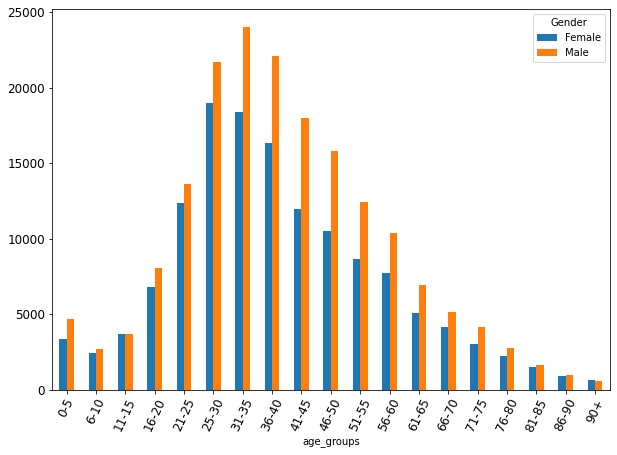

In [ ]:
age_gender.plot(kind="bar", rot=65,fontsize=12,figsize = (10,7))

In [ ]:
county_daily_data_selected = county_daily_data[county_daily_data["county"].isin(["Nairobi", "Mombasa"])]
county_daily_data_selected = county_daily_data_selected[[ "county", "lab_results", "date_of_lab_confirmation"]].\
                                groupby(["county", "date_of_lab_confirmation"]).count().reset_index()

fig = px.line(county_daily_data_selected, x="date_of_lab_confirmation" , y = "lab_results" , color = "county")
fig.update_traces(mode = 'lines')
fig.update_layout()
fig.show()

In [ ]:
county_daily_data.head()

,sex,age_years,lab_results,date_of_lab_confirmation,outcome,county,Year,Month,Week,Month_year,year_month
0,F,27.0,Positive,2020-03-12,Discharge,Kajiado,2020,Mar,11,2020-03,Mar-2020
1,F,48.0,Positive,2020-03-14,Discharge,Nairobi,2020,Mar,11,2020-03,Mar-2020
2,M,27.0,Positive,2020-03-14,Discharge,Nairobi,2020,Mar,11,2020-03,Mar-2020
3,F,31.0,Positive,2020-03-17,Discharge,Nairobi,2020,Mar,12,2020-03,Mar-2020
4,F,42.0,Positive,2020-03-17,Discharge,Nairobi,2020,Mar,12,2020-03,Mar-2020


In [ ]:
county_daily_data.head()

,sex,age_years,lab_results,date_of_lab_confirmation,outcome,county,Year,Month,Week,Month_year,year_month
0,F,27.0,Positive,2020-03-12,Discharge,Kajiado,2020,Mar,11,2020-03,Mar-2020
1,F,48.0,Positive,2020-03-14,Discharge,Nairobi,2020,Mar,11,2020-03,Mar-2020
2,M,27.0,Positive,2020-03-14,Discharge,Nairobi,2020,Mar,11,2020-03,Mar-2020
3,F,31.0,Positive,2020-03-17,Discharge,Nairobi,2020,Mar,12,2020-03,Mar-2020
4,F,42.0,Positive,2020-03-17,Discharge,Nairobi,2020,Mar,12,2020-03,Mar-2020


In [ ]:
county_daily_data["date_of_lab_confirmation"] = pd.to_datetime(county_daily_data["date_of_lab_confirmation"])
county_daily_data["Date"] = county_daily_data["date_of_lab_confirmation"]#.dt.date
county_daily_data.set_index("Date", inplace = True)


In [ ]:
    data=county_daily_data.loc["2020-03-12" : "2020-06-12"]
    data = data[data["county"] == "Nairobi"]
    data = data[["county","lab_results", "date_of_lab_confirmation"]].groupby(["county","date_of_lab_confirmation"]).count().reset_index()
    fig = px.line(data, x="date_of_lab_confirmation" , y = "lab_results" , color = "county")
    fig.update_yaxes(title = "Reported Cases", showline=True, linewidth = 0.2, linecolor = "gray", gridcolor = "gainsboro")
    fig.update_xaxes(title = "Date Reported", showgrid=False)
    fig.update_traces(mode = 'lines', marker_color = "#7086CE")
    fig.update_layout(paper_bgcolor="#EDEDED",plot_bgcolor = "#EDEDED",uniformtext_minsize = 3, font_color = "#4F4F4F", bargap =0.05)
 
fig.show()


In [ ]:
filename, extension = os.path.splitext("covid_monthly_data.fastq")
#extension

print(f"{filename}_.fasta")

covid_monthly_data_.fasta


In [57]:
! ls

Admin2
Covid-19_cleaned_07-02-2022.csv
Covid-19_cleaned_07-02-2022.txt
Covid-19_cleaned_07-02-2022.xlsx
KWTRP serosurveillance data_Dashboard_09Sep2022.xlsx
KWTRP_serosurveillance_data_Dashboard_09Sep2022.txt
LICENSE
README.md
age_gender_cases_data.csv
age_gender_death_cases_data.csv
assets
cases_per_county.csv
county_cases_spatial.r
county_daily_data.csv
county_vaccination.csv
covid_19_kenya.py
covid_daily_data.csv
covid_data_processed.csv
covid_monthly_data.csv
data_preprocessing.ipynb
death_cases.csv
kenya
kenyan-counties
plot_county_covid_cases.png
plot_county_death_cases.png
provice_level_cases.csv


## Seroprecalence Data preprocessing

In [60]:
sero_data = pd.read_excel("KWTRP_serosurveillance_data_Dashboard_09Sep2022.xlsx") #requires openpyxl

In [264]:
sero_data["Period"] = sero_data[["Month(s)", "Year"]].astype(str).agg(" ".join, axis=1)

In [152]:
sero_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Population                     137 non-null    object 
 1   Region                         137 non-null    object 
 2   Age in years                   137 non-null    object 
 3   Sex                            137 non-null    object 
 4   Month(s)                       137 non-null    object 
 5   Year                           137 non-null    int64  
 6   Anti-spike IgG seroprevalence  137 non-null    float64
 7   LB 95% margin of error         137 non-null    float64
 8   UB 95% margin of error         137 non-null    float64
 9   Source                         137 non-null    object 
 10  Period                         137 non-null    object 
dtypes: float64(3), int64(1), object(7)
memory usage: 11.9+ KB


In [73]:
sero_data["Source"].value_counts()

doi: 10.1001/jama.2021.15265       32
10.1101/2022.02.07.22270012        30
TBD - manuscript in prep           20
doi: 10.1126/science.abe1916       16
doi: 10.1038/s41467-021-24062-3    16
10.1093/cid/ciab346                11
10.1093/ofid/ofab314                8
10.1101/2021.02.05.21250735         4
Name: Source, dtype: int64

In [143]:
blood_donors = sero_data[sero_data["Population"] == "Blood donors"][["Population","Age in years"]]
blood_donors = blood_donors.groupby("Age in years").count().reset_index()
blood_donors = blood_donors.rename(columns={"Population":"Frequency"})
fig = go.Figure()
fig.add_trace(go.Bar(x = blood_donors["Age in years"], y = blood_donors["Frequency"]))
fig.update_layout(uniformtext_minsize = 3, font_color = "#000000", bargap =0.2,font_size=10,autosize=False, width = 600, height=800)
fig.show()


In [127]:
sero_data["Population"].value_counts()

Blood donors      64
HDSS residents    50
Health workers    11
Trucking crews     8
ANC attendees      4
Name: Population, dtype: int64

In [289]:
Health_workers = sero_data[sero_data["Population"] == "Health workers"][["Population","Age in years"]]
Health_workers = Health_workers.groupby("Age in years").count().reset_index()
Health_workers

,Age in years,Population
0,18 - 30,1
1,31 - 40,1
2,41 - 50,1
3,51 - 60,1
4,>60,1
5,≥18,6


In [296]:
Truck_crews = sero_data[sero_data["Population"] == "Trucking crews"][["Population","Age in years"]]
Truck_crews = Truck_crews.groupby("Age in years").count().reset_index()
Truck_crews

,Age in years,Population
0,30 - 39,1
1,40 - 49,1
2,50 - 59,1
3,<30,1
4,≥18,3
5,≥60,1


In [300]:
anc_attendees = sero_data[sero_data["Population"] == "ANC attendees"][["Population","Age in years"]]
anc_attendees = anc_attendees.groupby("Age in years").count().reset_index()
anc_attendees

,Age in years,Population
0,17 - 45,1
1,UNK,3


In [142]:
HDSS = sero_data[sero_data["Population"] == "HDSS residents"][["Population","Age in years"]]
HDSS = HDSS.groupby("Age in years").count().reset_index()
HDSS = HDSS.rename(columns={"Population":"Frequency"})
HDSS["Values"] = [3,4,5,6,7,2,1,8]
HDSS = HDSS.sort_values(by="Values")
fig = go.Figure()
fig.add_trace(go.Bar(x = HDSS["Age in years"], y = HDSS["Frequency"]))
fig.update_layout(uniformtext_minsize = 3, font_color = "#000000", bargap =0.2,font_size=10,autosize=False, width = 600, height=800)
fig.show()

In [324]:

from plotly.subplots import make_subplots

fig = make_subplots(rows = 3,cols=3)
fig.add_trace(go.Bar(x = blood_donors["Age in years"], y = blood_donors["Frequency"],name = "Blood donors"), row=1,col=1)
fig.add_trace(go.Bar(x = HDSS["Age in years"], y = HDSS["Frequency"], name = "HDSS"), row=1,col=2)
fig.add_trace(go.Bar(x = Health_workers["Age in years"], y = Health_workers["Population"],name = "Health workers"), row=2,col=1)
fig.add_trace(go.Bar(x = Truck_crews["Age in years"], y = Truck_crews["Population"],name = "Truck crews"), row=2,col=2)
fig.add_trace(go.Bar(x = anc_attendees["Age in years"], y = anc_attendees["Population"],name = "ANC Attendees"), row=2,col=3)
fig.update_yaxes( showline=True, linewidth = 0.2, linecolor = "gray", gridcolor = "gainsboro")
fig.update_xaxes( showline=True, linewidth = 0.2,linecolor = "gray")
fig.update_traces(width = 0.5)
fig.update_layout(height=700, width=900, title = "Sero-study population categories", plot_bgcolor = "#FFFAFA", paper_bgcolor = "#FFFAFA")

fig.show()

In [102]:
gender = sero_data["Sex"].value_counts().to_frame()
gender["%"] = round(gender["Sex"]/gender["Sex"].sum() * 100, 2 )
fig = px.pie(gender, values = "%", names = gender.index, hole = .4)
#gender
fig.update_layout(height = 400, width = 500)
fig.show()

In [95]:
population = sero_data["Population"].value_counts().to_frame()
population["%"] = round(population["Population"]/population["Population"].sum() * 100, 2)
fig = px.pie(population, values = "%",names=population.index, hole = .4)
fig.update_layout(height = 400, width = 500)



In [153]:
sero_data.head()

,Population,Region,Age in years,Sex,Month(s),Year,Anti-spike IgG seroprevalence,LB 95% margin of error,UB 95% margin of error,Source,Period
0,Blood donors,National,15 - 64,All,Apr - Jun,2020,4.3,2.9,4.8,doi: 10.1126/science.abe1916,Apr - Jun-2020
1,Blood donors,National,15 - 64,Male,Apr - Jun,2020,3.6,1.9,5.8,doi: 10.1126/science.abe1916,Apr - Jun-2020
2,Blood donors,National,15 - 64,Female,Apr - Jun,2020,4.8,3.5,6.4,doi: 10.1126/science.abe1916,Apr - Jun-2020
3,Blood donors,National,15 - 24,All,Apr - Jun,2020,4.4,2.7,6.4,doi: 10.1126/science.abe1916,Apr - Jun-2020
4,Blood donors,National,25 - 34,All,Apr - Jun,2020,4.2,2.3,6.0,doi: 10.1126/science.abe1916,Apr - Jun-2020


### Distribution by Period

In [265]:
period = sero_data[["Population","Period"]].groupby(["Period","Population"])["Period"].count().to_frame()
period.index.names = ["Periods","Population"]
period = period.reset_index()
period = period.rename(columns = {"Periods" :"Period", "Period":"Frequency"})

period

,Period,Population,Frequency
0,Apr - Jun 2020,Blood donors,16
1,Aug - Sep 2020,Blood donors,16
2,Dec - Apr 2021,HDSS residents,10
3,Feb - May 2021,HDSS residents,10
4,Feb - May 2022,HDSS residents,10
5,Jan - Mar 2021,Blood donors,16
6,Jan - May 2021,HDSS residents,10
7,Jul - Aug 2020,ANC attendees,1
8,Jul - Dec 2020,Health workers,11
9,Jun - Aug 2020,Blood donors,16


In [275]:
fig = px.bar(period, x = "Period", y = "Frequency", barmode="group", color = "Population")
fig.update_layout(height = 400, width = 1000, bargap = 0.005)

In [287]:
region = sero_data["Region"].value_counts().to_frame()
region["%"] = round(region["Region"]/region["Region"].sum() * 100, 2)
fig = px.pie(region, values = "%",names=region.index, hole = .4)
fig.update_layout(height = 500, width = 700)

In [325]:
sero_data.head()

,Population,Region,Age in years,Sex,Month(s),Year,Anti-spike IgG seroprevalence,LB 95% margin of error,UB 95% margin of error,Source,Period
0,Blood donors,National,15 - 64,All,Apr - Jun,2020,4.3,2.9,4.8,doi: 10.1126/science.abe1916,Apr - Jun 2020
1,Blood donors,National,15 - 64,Male,Apr - Jun,2020,3.6,1.9,5.8,doi: 10.1126/science.abe1916,Apr - Jun 2020
2,Blood donors,National,15 - 64,Female,Apr - Jun,2020,4.8,3.5,6.4,doi: 10.1126/science.abe1916,Apr - Jun 2020
3,Blood donors,National,15 - 24,All,Apr - Jun,2020,4.4,2.7,6.4,doi: 10.1126/science.abe1916,Apr - Jun 2020
4,Blood donors,National,25 - 34,All,Apr - Jun,2020,4.2,2.3,6.0,doi: 10.1126/science.abe1916,Apr - Jun 2020


In [326]:
blood_donors.head()

,Age in years,Frequency
0,15 - 24,3
1,15 - 64,33
2,16 - 24,1
3,16 - 64,11
4,25 - 34,4


In [344]:
BD_sero = sero_data[sero_data["Population"] == "Blood donors"]

BD_sero.head(n=20)

,Population,Region,Age in years,Sex,Month(s),Year,Anti-spike IgG seroprevalence,LB 95% margin of error,UB 95% margin of error,Source,Period
0,Blood donors,National,15 - 64,All,Apr - Jun,2020,4.3,2.9,4.8,doi: 10.1126/science.abe1916,Apr - Jun 2020
1,Blood donors,National,15 - 64,Male,Apr - Jun,2020,3.6,1.9,5.8,doi: 10.1126/science.abe1916,Apr - Jun 2020
2,Blood donors,National,15 - 64,Female,Apr - Jun,2020,4.8,3.5,6.4,doi: 10.1126/science.abe1916,Apr - Jun 2020
3,Blood donors,National,15 - 24,All,Apr - Jun,2020,4.4,2.7,6.4,doi: 10.1126/science.abe1916,Apr - Jun 2020
4,Blood donors,National,25 - 34,All,Apr - Jun,2020,4.2,2.3,6.0,doi: 10.1126/science.abe1916,Apr - Jun 2020
5,Blood donors,National,35 - 44,All,Apr - Jun,2020,5.2,3.3,7.7,doi: 10.1126/science.abe1916,Apr - Jun 2020
6,Blood donors,National,45 - 54,All,Apr - Jun,2020,3.0,1.1,5.4,doi: 10.1126/science.abe1916,Apr - Jun 2020
7,Blood donors,National,55 - 64,All,Apr - Jun,2020,2.9,0.7,5.7,doi: 10.1126/science.abe1916,Apr - Jun 2020
8,Blood donors,Central,15 - 64,All,Apr - Jun,2020,4.9,1.9,9.7,doi: 10.1126/science.abe1916,Apr - Jun 2020
9,Blood donors,Mombasa,15 - 64,All,Apr - Jun,2020,7.8,5.4,10.8,doi: 10.1126/science.abe1916,Apr - Jun 2020


In [358]:
sero_plot = px.box(sero_data, x = "Population", y = "Anti-spike IgG seroprevalence",color="Population", points="all")#boxmode="overlay",facet_col = "Population",
sero_plot.show()